In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras import Model
from keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

2024-07-01 02:38:12.613712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 02:38:12.613746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 02:38:12.614576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 02:38:12.619967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)
data_dir = Path(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [5]:
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [6]:
image_df = pd.concat([filepaths, labels], axis=1)
# random_index = np.random.randint(0, len(image_df), 16)
# print(random_index)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
#     ax.set_title(image_df.Label[random_index[i]])
# plt.tight_layout()
# plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape
test_df.shape

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [8]:
batch_size = 32
img_size = (200, 200)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 13540 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.
Found 4231 validated image filenames belonging to 3 classes.


In [9]:
print(train_images.classes[0:10])

[1, 0, 1, 2, 0, 0, 1, 1, 0, 1]


In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
])

pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

2024-07-01 02:38:14.802052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 02:38:14.802323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 02:38:14.864595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
inputs = pretrained_model.inputs
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)

In [12]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [13]:
# # Create checkpoint callback
# checkpoint_path = "bags_classification_model_checkpoint"
# checkpoint_callback = ModelCheckpoint(checkpoint_path,
#                                       save_weights_only=True,
#                                       monitor="val_accuracy",
#                                       save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=50)

In [14]:
# Train the model
history = model.fit(train_images,
                    steps_per_epoch=len(train_images),
                    epochs=200,
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    callbacks=[early_stopping_callback])

Epoch 1/200


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
2024-07-01 02:38:16.767388: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-01 02:38:17.010207: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 02:38:17.095346: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 02:38:17.118709: W external/local_tsl/tsl/frame

424/424 [==============================] - 134s 305ms/step - loss: 0.7106 - accuracy: 0.8302 - val_loss: 0.1464 - val_accuracy: 0.9527
Epoch 2/200
424/424 [==============================] - 128s 301ms/step - loss: 0.2097 - accuracy: 0.9403 - val_loss: 0.1096 - val_accuracy: 0.9660
Epoch 3/200
424/424 [==============================] - 126s 298ms/step - loss: 0.1442 - accuracy: 0.9560 - val_loss: 0.0893 - val_accuracy: 0.9702
Epoch 4/200
424/424 [==============================] - 126s 298ms/step - loss: 0.1073 - accuracy: 0.9657 - val_loss: 0.0807 - val_accuracy: 0.9728
Epoch 5/200
424/424 [==============================] - 125s 296ms/step - loss: 0.0816 - accuracy: 0.9744 - val_loss: 0.0786 - val_accuracy: 0.9743
Epoch 6/200
424/424 [==============================] - 129s 305ms/step - loss: 0.0657 - accuracy: 0.9781 - val_loss: 0.0721 - val_accuracy: 0.9755
Epoch 7/200
424/424 [==============================] - 126s 297ms/step - loss: 0.0537 - accuracy: 0.9821 - val_loss: 0.0667 - val_

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

133/133 [==============================] - 45s 334ms/step - loss: 0.0908 - accuracy: 0.9887
Test loss: 0.09082289040088654
Test accuracy: 0.988655149936676


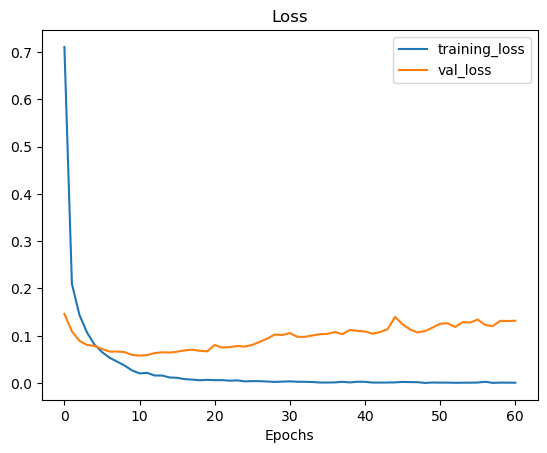

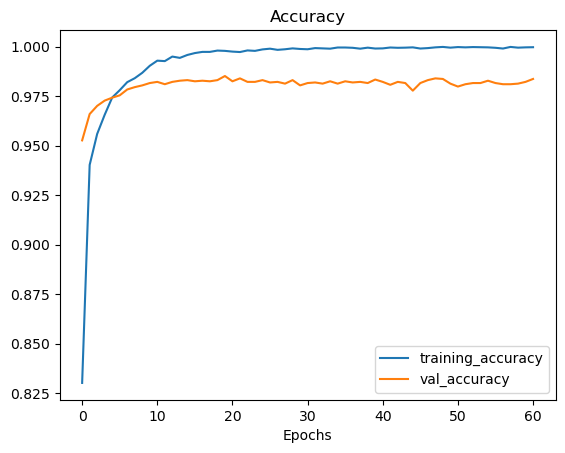

In [16]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [17]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 12 predictions: {pred[:12]}')

133/133 [==============================] - 35s 266ms/step
The first 12 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Recycle', 'Recycle', 'UnRecycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic']


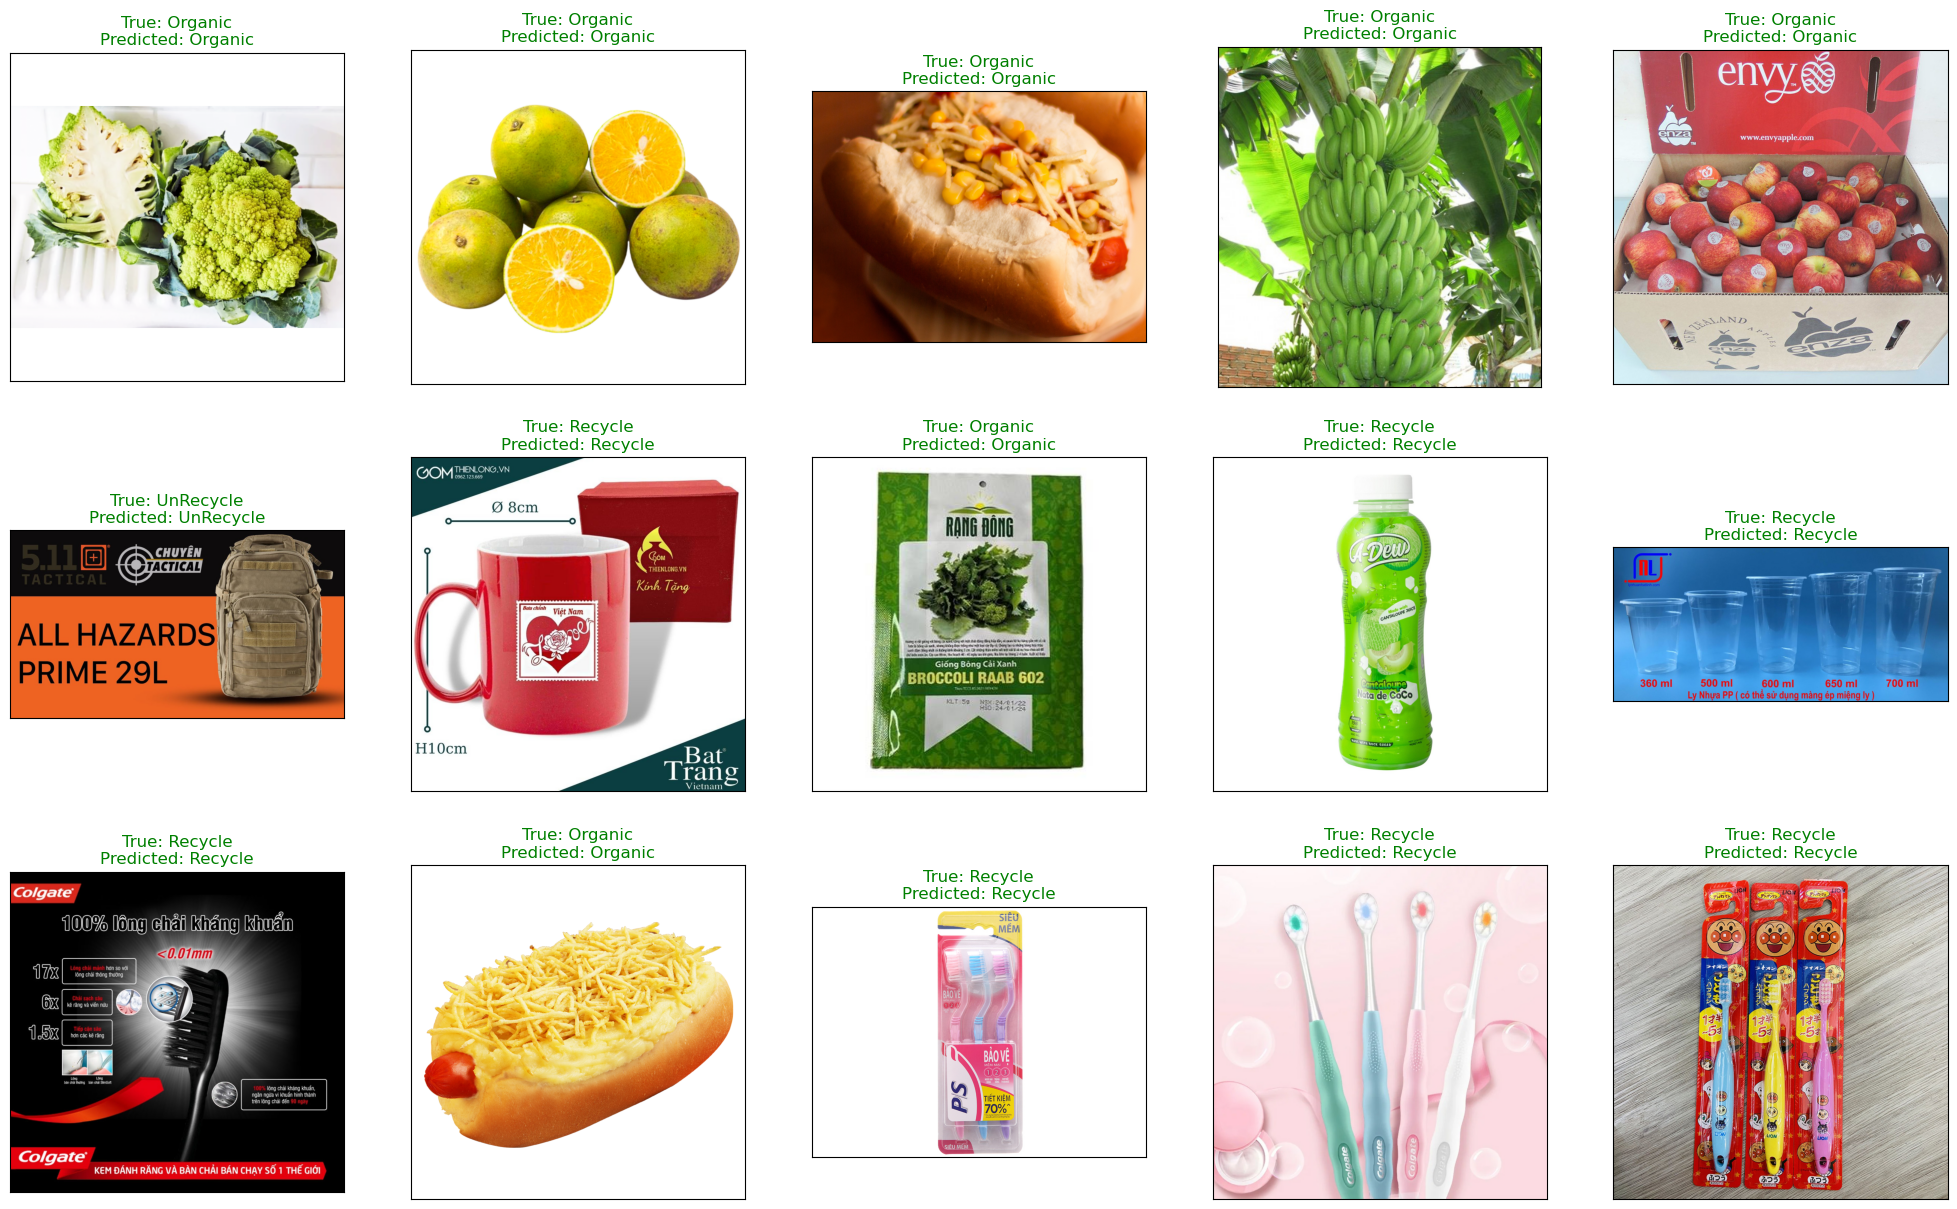

<Figure size 640x480 with 0 Axes>

In [18]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [19]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.993224,0.987647,0.990428,1781.000000
Recycle,0.983425,0.988279,0.985846,1621.000000
UnRecycle,0.989170,0.991556,0.990361,829.000000
accuracy,0.988655,0.988655,0.988655,0.988655
macro avg,0.988606,0.989161,0.988879,4231.000000
weighted avg,0.988676,0.988655,0.988660,4231.000000


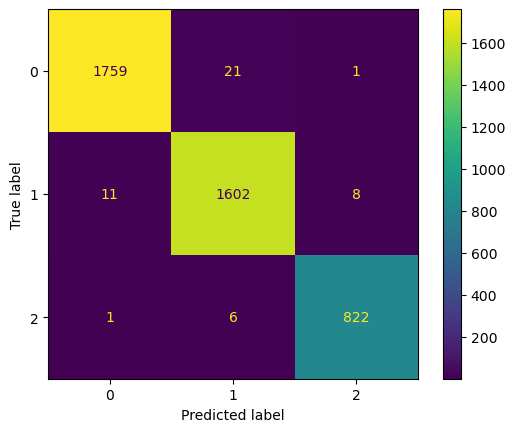

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()